In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [78]:
data = fetch_california_housing()
data.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [79]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df['price'] = data.target * 100_000
df.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
price         0
dtype: int64

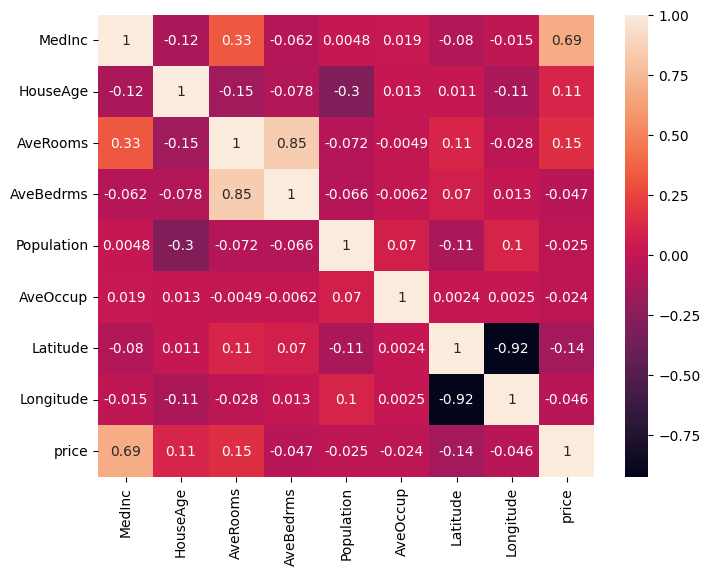

In [80]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [81]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,452600.0
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,358500.0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,352100.0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,341300.0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,342200.0


In [82]:
exclude_price_df = df.drop('price', axis=1)
exclude_price_df.corr()[exclude_price_df.corr() < 1].unstack().transpose().sort_values(ascending=False).drop_duplicates()

AveBedrms   AveRooms      0.847621
AveRooms    MedInc        0.326895
Latitude    AveRooms      0.106389
Population  Longitude     0.099773
            AveOccup      0.069863
Latitude    AveBedrms     0.069721
MedInc      AveOccup      0.018766
AveBedrms   Longitude     0.013344
HouseAge    AveOccup      0.013191
            Latitude      0.011173
MedInc      Population    0.004834
AveOccup    Longitude     0.002476
            Latitude      0.002366
            AveRooms     -0.004852
            AveBedrms    -0.006181
Longitude   MedInc       -0.015176
            AveRooms     -0.027540
AveBedrms   MedInc       -0.062040
Population  AveBedrms    -0.066197
AveRooms    Population   -0.072213
AveBedrms   HouseAge     -0.077747
Latitude    MedInc       -0.079809
HouseAge    Longitude    -0.108197
Population  Latitude     -0.108785
MedInc      HouseAge     -0.119034
AveRooms    HouseAge     -0.153277
Population  HouseAge     -0.296244
Latitude    Longitude    -0.924664
MedInc      MedInc  

In [57]:
vif_data = pd.DataFrame()
vif_data["feature"] = data.feature_names
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(data.feature_names))]
print(vif_data)

      feature         VIF
0      MedInc   19.624998
1    HouseAge    7.592663
2    AveRooms   47.956351
3   AveBedrms   45.358192
4  Population    2.936078
5    AveOccup    1.099530
6    Latitude  568.497332
7   Longitude  640.064211


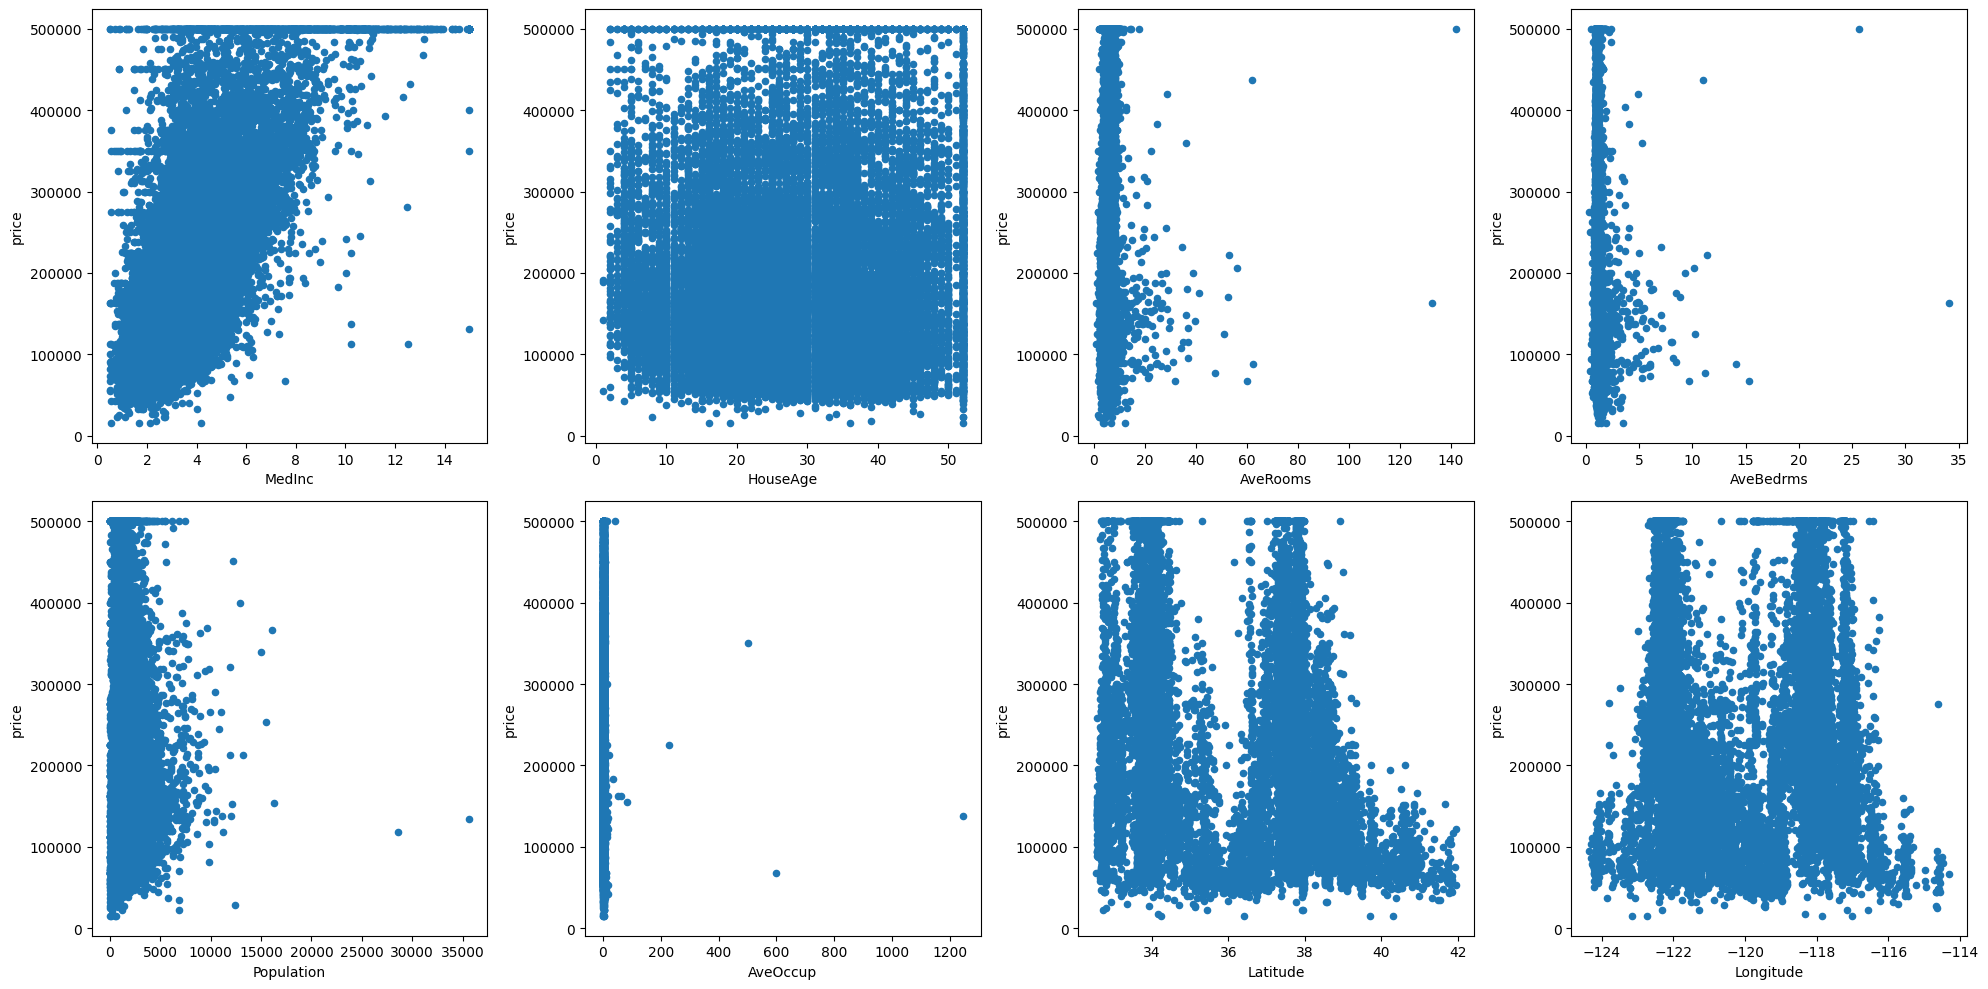

In [6]:
# make a 2x4 grid of scatter plots
fig, ax = plt.subplots(2, 4, figsize=(20,10))

for i, feature in enumerate(data.feature_names):
    df.plot(feature, 'price', subplots=True, kind='scatter', ax=ax[i//4, i%4])
    plt.xlabel(feature)
    plt.ylabel('price')

plt.tight_layout()
plt.show()

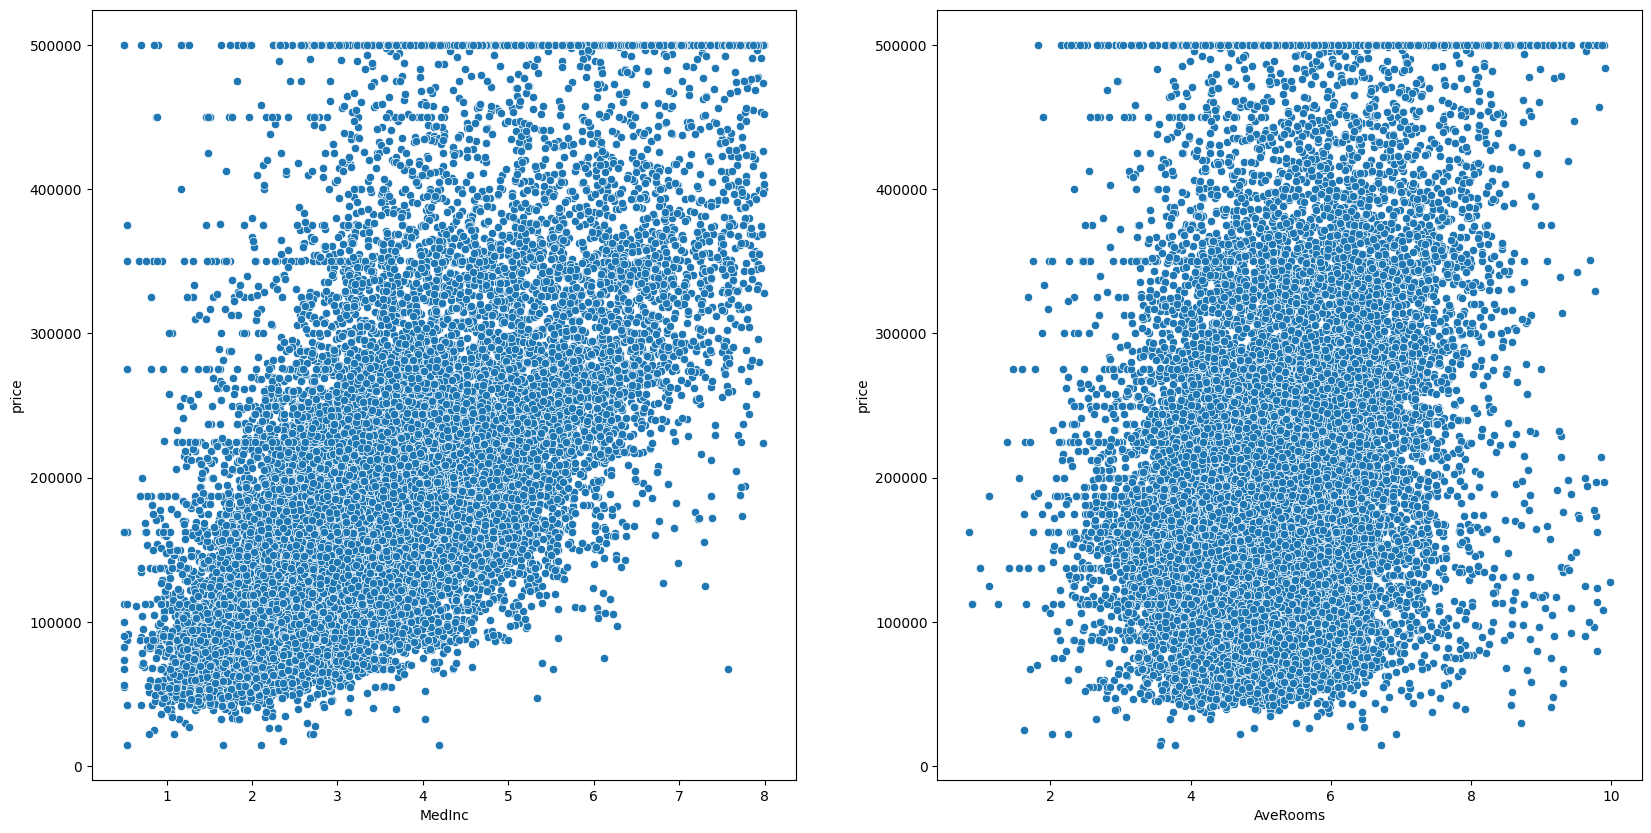

In [59]:
fix, ax = plt.subplots(1, 2, figsize=(20,10))

sns.scatterplot(data=df[df['MedInc'] < 8], x='MedInc', y='price', ax=ax[0])
sns.scatterplot(data=df[df['AveRooms'] < 10], x='AveRooms', y='price', ax=ax[1])
plt.show()

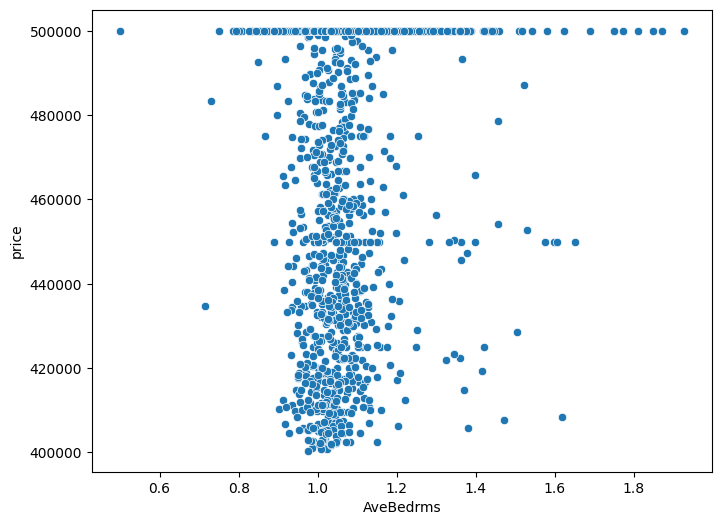

In [61]:
# plot 'AveRooms' against 'Price' and remove data with 'AveRooms' > 10
plt.figure(figsize=(8,6))
sns.scatterplot(data=df[(df['price'] > 400_000) & (df['AveBedrms'] < 2)], x='AveBedrms', y='price')
plt.show()

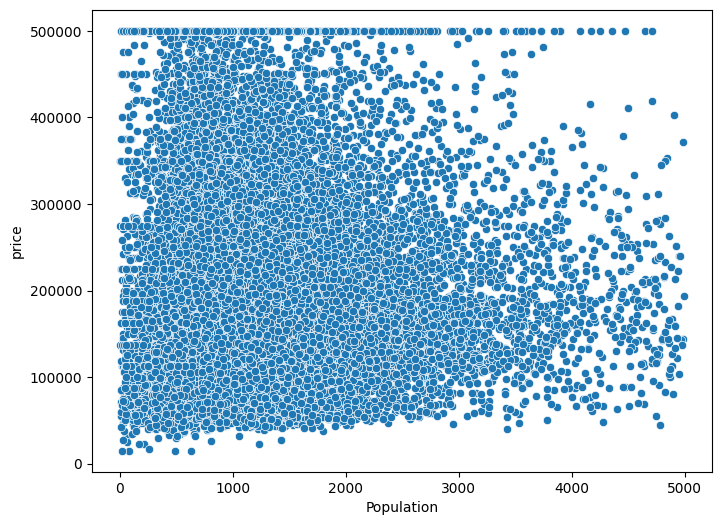

In [44]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df[df['Population'] < 5_000], x='Population', y='price')
plt.show()

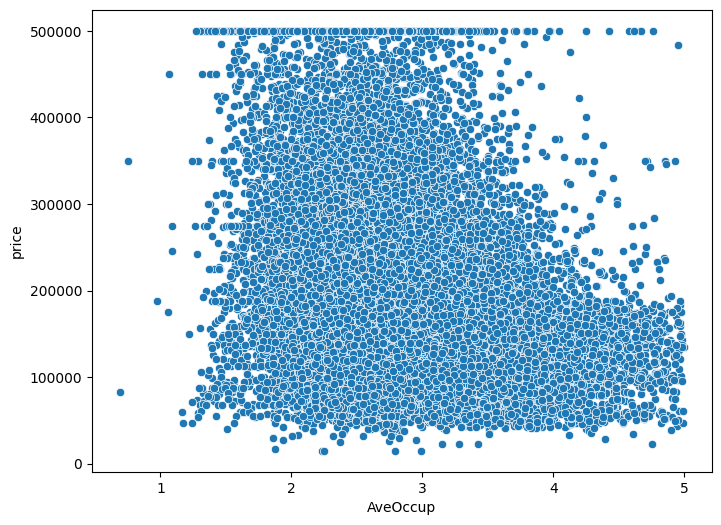

In [49]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df[df['AveOccup'] < 5], x='AveOccup', y='price')
plt.show()

In [7]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(df.drop('price', axis=1))

In [8]:
epochs = 5_000
loss_history = list()
intercept_history = list()
coefficients_history = np.zeros((scaled_X.shape[1], epochs))

def predict(intercept: float, coefficient: list, data: list) -> list:
    return intercept + np.dot(data, coefficient)

def loss_function(coefficients, errors, regularization_term):
    return np.mean(np.square(errors)) + regularization_term * np.sum(np.abs(coefficients))

def soft_threshold(rho, lambda_):
    if rho < -lambda_:
        return (rho + lambda_)
    elif rho > lambda_:
        return (rho - lambda_)
    else:
        return 0

def lasso_regression(x, y, epochs, learning_rate = 0.1, regularization_term = 0.001):
    intercept, coefficients = 0, np.zeros(x.shape[1])
    length = x.shape[0]

    intercept_history.append(intercept)
    coefficients_history[:, 0] = coefficients
    loss_history.append(loss_function(coefficients, y, regularization_term))

    for i in range(1, epochs):
        predictions = predict(intercept, coefficients, x)
        errors = predictions - y
        intercept = intercept - learning_rate * np.sum(errors) / length
        intercept_history.append(intercept)
        
        for j in range(len(coefficients)):
            gradient = np.dot(x[:, j], errors) / length
            temp_coef = coefficients[j] - learning_rate * gradient
            coefficients[j] = soft_threshold(temp_coef, regularization_term)
            coefficients_history[j, i] = coefficients[j]
        
        loss_history.append(loss_function(coefficients, errors, regularization_term))

    return intercept, coefficients

b, x = lasso_regression(scaled_X, data.target, epochs)
print(f"intercept: {b}")
print(f"coefficients: {x}")

intercept: 2.068558169089139
coefficients: [ 0.77694558  0.12482638 -0.12889922  0.16873121  0.         -0.02943661
 -0.79605577 -0.75955862]


In [9]:
print(f"loss: {loss_history[-1]}")
for coef, feature in zip(x, data.feature_names):
    print(f"{feature}: {coef}")

loss: 0.5325639133083526
MedInc: 0.776945583723752
HouseAge: 0.12482637796785734
AveRooms: -0.1288992228493256
AveBedrms: 0.16873121107078376
Population: 0.0
AveOccup: -0.029436607816215973
Latitude: -0.7960557693310637
Longitude: -0.7595586199718125


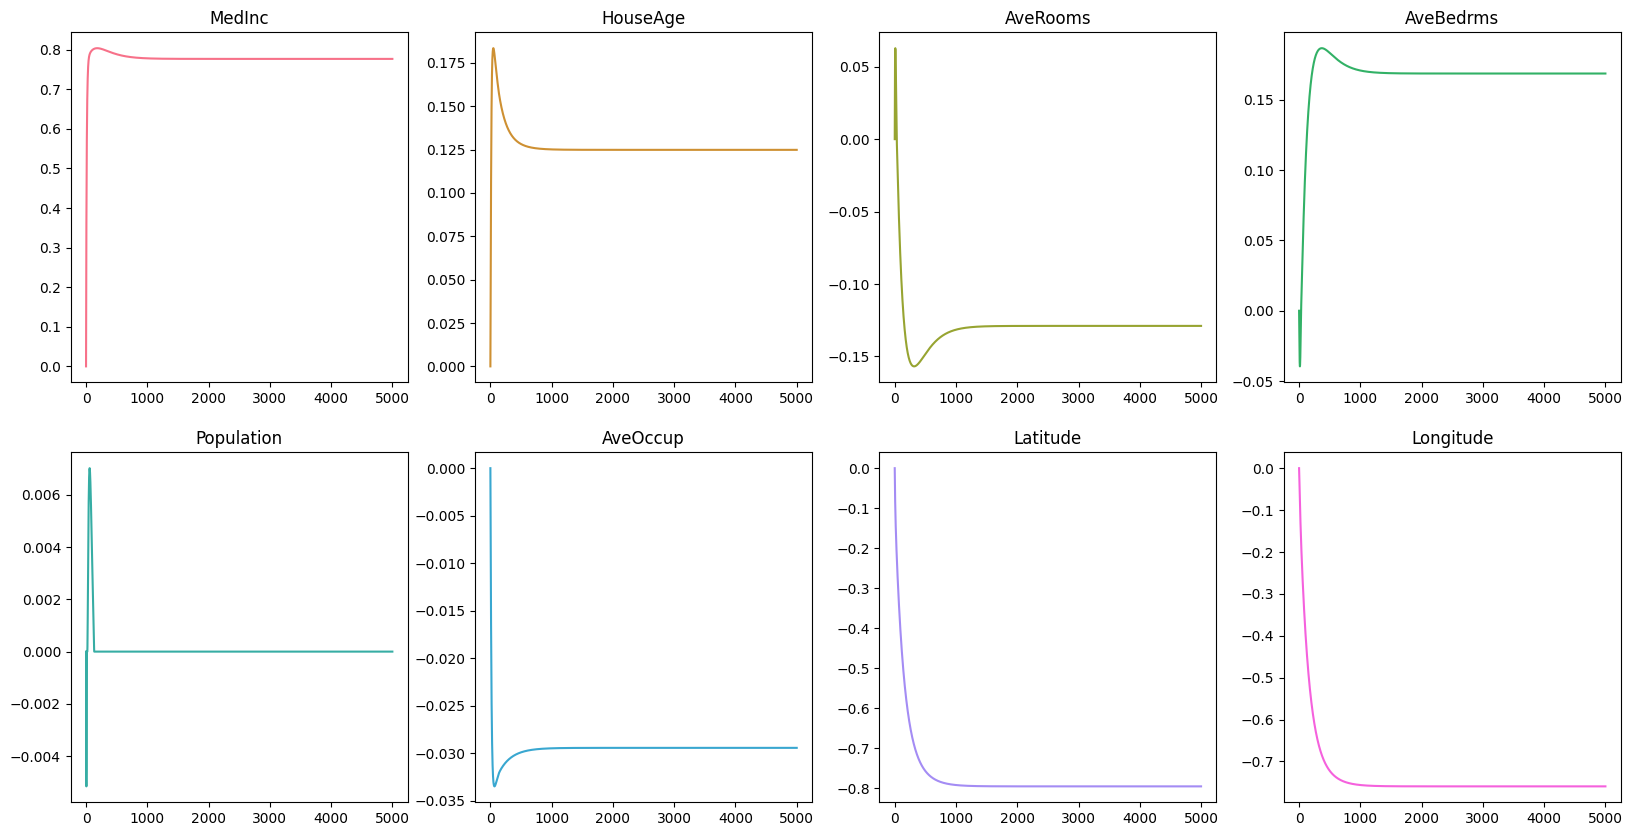

In [15]:
fix, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, color in zip(range(8), sns.color_palette("husl", 8)):
    ax[i//4, i%4].plot(coefficients_history[i,:5000], color=color)
    ax[i//4, i%4].set_title(data.feature_names[i])